In [247]:
# import random
# import pandas as pd

# def generate_string(member=True, max_len=20):
#     if member:
#         n = random.randint(1, max_len // 3)
#         return 'a' * n + 'b' * n + 'c' * n
#     else:
#         length = random.randint(1, max_len)
#         string = ''.join(random.choices(['a', 'b', 'c'], k=length))
#         while string == ''.join(sorted(string)):
#             string = ''.join(random.choices(['a', 'b', 'c'], k=length))
#         return string

# def create_dataset(num_samples=100, max_len=20):
#     data = []
#     for _ in range(num_samples // 2):
#         data.append((generate_string(True, max_len), 1))
#         data.append((generate_string(False, max_len), 0))
#     random.shuffle(data)
#     return data

# dataset = create_dataset()
# df = pd.DataFrame(dataset, columns=['string', 'label'])
# df.to_csv('formal_language_dataset.csv', index=False)

In [248]:
import random
import pandas as pd
import os

# def generate_string(member=True, max_len=20):
#     if member:
#         n = random.randint(1, max_len // 3)
#         return 'a' * n + 'b' * n + 'c' * n
#     else:
#         length = random.randint(1, max_len)
#         string = ''.join(random.choices(['a', 'b', 'c'], k=length))
#         while string == ''.join(sorted(string)):
#             string = ''.join(random.choices(['a', 'b', 'c'], k=length))
#         return string

# def generate_batch(batch_size=100, max_len=20):
#     data = []
#     for _ in range(batch_size // 2):
#         data.append((generate_string(True, max_len), 1))
#         data.append((generate_string(False, max_len), 0))
#     random.shuffle(data)
#     return data

# def append_to_csv(data, filename='formal_language_dataset.csv'):
#     df = pd.DataFrame(data, columns=['string', 'label'])
#     if os.path.exists(filename):
#         df.to_csv(filename, mode='a', header=False, index=False)
#     else:
#         df.to_csv(filename, mode='w', header=True, index=False)

# # Generate and append data
# batch_size = 20
# new_data = generate_batch(batch_size)
# append_to_csv(new_data)
# print(f"Appended {batch_size} new samples to formal_language_dataset.csv")

In [249]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torch.nn.utils.rnn import pad_sequence

class PaddedStringDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.char_to_idx = {'a': 1, 'b': 2, 'c': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        string, label = self.data.iloc[idx]
        input_seq = [self.char_to_idx[char] for char in string]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(label, dtype=torch.float)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    return sequences_padded, torch.tensor(labels)

In [250]:
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out, _ = self.rnn(packed, h0)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = self.fc(out[torch.arange(out.size(0)), lengths - 1])
        return out

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(packed, (h0, c0))
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = self.fc(out[torch.arange(out.size(0)), lengths - 1])
        return out

In [251]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [252]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model_with_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            lengths = torch.tensor([len(seq) for seq in sequences]).to(device)

            outputs = model(sequences.unsqueeze(-1).float(), lengths)
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return accuracy, f1

In [253]:
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('formal_language_dataset.csv')
average_length = sum(len(sample[0]) for sample in df.values) / len(df)
print(f"Average balanced dataset length: {average_length}")

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Prepare the datasets and dataloaders
train_dataset = PaddedStringDataset(train_df)
val_dataset = PaddedStringDataset(val_df)
# test_dataset = PaddedStringDataset(df_long)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Define hyper-parameters to search
hidden_sizes = [25, 50, 100]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

best_rnn_params = None
best_lstm_params = None
best_rnn_accuracy = 0
best_lstm_accuracy = 0

def hyperparameter_search(model_class, hidden_sizes, learning_rates, batch_sizes):
    best_params = None
    best_accuracy = 0
    max_f1 = 0

    for hidden_size in hidden_sizes:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                # Update data loader with new batch size
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
                # Initialize model, criterion, and optimizer
                model = model_class(input_size=1, hidden_size=hidden_size, output_size=1).to(device)
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                criterion = nn.BCEWithLogitsLoss()

                # Train the model
                model.train()
                for epoch in range(5):
                    for sequences, labels in train_loader:
                        sequences = sequences.to(device)
                        labels = labels.to(device)
                        lengths = torch.tensor([len(seq) for seq in sequences]).to(device)
                        outputs = model(sequences.unsqueeze(-1).float(), lengths)
                        loss = criterion(outputs.squeeze(), labels)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Evaluate the model
                accuracy, f1 = evaluate_model_with_metrics(model, val_loader)
                # Update best parameters if necessary
                if f1 > max_f1:
                    max_f1 = f1
                    best_params = (hidden_size, learning_rate, batch_size)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    # best_params = (hidden_size, learning_rate, batch_size)

    return best_params, max_f1, best_accuracy

# Perform hyper-parameter search for RNN
# best_rnn_params, f1, best_accuracy = hyperparameter_search(ElmanRNN, hidden_sizes, learning_rates, batch_sizes)
# print(f'Best RNN Params: Hidden Size={best_rnn_params[0]}, Learning Rate={best_rnn_params[1]}, Batch Size={best_rnn_params[2]}, accuracy={best_accuracy * 100:.2f}%, f1={max_f1:.2f}')
best_rnn_params, max_f1, best_accuracy = hyperparameter_search(ElmanRNN, hidden_sizes, learning_rates, batch_sizes)
print(f'Best RNN Params: Hidden Size={best_rnn_params[0]}, Learning Rate={best_rnn_params[1]}, Batch Size={best_rnn_params[2]}, accuracy={best_accuracy * 100:.2f}%, f1={max_f1:.2f}')

# Perform hyper-parameter search for LSTM
best_lstm_params, max_f1, best_accuracy = hyperparameter_search(LSTM, hidden_sizes, learning_rates, batch_sizes)
print(f'Best LSTM Params: Hidden Size={best_lstm_params[0]}, Learning Rate={best_lstm_params[1]}, Batch Size={best_lstm_params[2]}, accuracy={best_accuracy * 100:.2f}%, f1={max_f1:.2f}')


Average balanced dataset length: 10.7145
Best RNN Params: Hidden Size=25, Learning Rate=0.001, Batch Size=32, accuracy=97.75%, f1=0.98
Best LSTM Params: Hidden Size=50, Learning Rate=0.01, Batch Size=64, accuracy=99.25%, f1=0.99


In [254]:
def train_model(model, optimizer, train_loader):
  criterion = nn.BCEWithLogitsLoss()
  model.train()
  for epoch in range(10):
      for sequences, labels in train_loader:
          sequences = sequences.to(device)
          labels = labels.to(device)
          lengths = torch.tensor([len(seq) for seq in sequences]).to(device)

          outputs = model(sequences.unsqueeze(-1).float(), lengths)
          loss = criterion(outputs.squeeze(), labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')

In [255]:
# Update data loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_rnn_params[2], shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=best_rnn_params[2], shuffle=False, collate_fn=collate_fn)

# Define and train the RNN with the best hyper-parameters
rnn_model = ElmanRNN(input_size=1, hidden_size=best_rnn_params[0], output_size=1).to(device)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=best_rnn_params[1])
train_model(rnn_model, rnn_optimizer, train_loader)

# Define and train the LSTM with the best hyper-parameters
lstm_model = LSTM(input_size=1, hidden_size=best_lstm_params[0], output_size=1).to(device)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=best_lstm_params[1])
train_model(lstm_model, lstm_optimizer, train_loader)

# Evaluate the models on the validation set
rnn_accuracy, rnn_f1 = evaluate_model_with_metrics(rnn_model, val_loader)
print(f'Final RNN Accuracy: {rnn_accuracy * 100:.2f}%, F1 Score: {rnn_f1:.2f}')

lstm_accuracy, lstm_f1 = evaluate_model_with_metrics(lstm_model, val_loader)
print(f'Final LSTM Accuracy: {lstm_accuracy * 100:.2f}%, F1 Score: {lstm_f1:.2f}')

Epoch [1/10], Loss: 0.6387
Epoch [2/10], Loss: 0.3312
Epoch [3/10], Loss: 0.2111
Epoch [4/10], Loss: 0.2206
Epoch [5/10], Loss: 0.2546
Epoch [6/10], Loss: 0.0518
Epoch [7/10], Loss: 0.0296
Epoch [8/10], Loss: 0.0876
Epoch [9/10], Loss: 0.0366
Epoch [10/10], Loss: 0.2155
Epoch [1/10], Loss: 0.1232
Epoch [2/10], Loss: 0.1103
Epoch [3/10], Loss: 0.0023
Epoch [4/10], Loss: 0.0023
Epoch [5/10], Loss: 0.0008
Epoch [6/10], Loss: 0.0206
Epoch [7/10], Loss: 0.0043
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0032
Epoch [10/10], Loss: 0.1344
Final RNN Accuracy: 96.95%, F1 Score: 0.97
Final LSTM Accuracy: 98.60%, F1 Score: 0.99


In [256]:
# Generate long test dataset
# def generate_long_string(member=True, min_len=21, max_len=100):
#     if member:
#         n = random.randint(min_len // 3, max_len // 3)
#         return 'a' * n + 'b' * n + 'c' * n
#     else:
#         length = random.randint(min_len, max_len)
#         string = ''.join(random.choices(['a', 'b', 'c'], k=length))
#         while string == ''.join(sorted(string)):
#             string = ''.join(random.choices(['a', 'b', 'c'], k=length))
#         return string

# def create_long_dataset(num_samples=10, min_len=21, max_len=100):
#     data = []
#     for _ in range(num_samples // 2):
#         data.append((generate_long_string(True, min_len, max_len), 1))
#         data.append((generate_long_string(False, min_len, max_len), 0))
#     random.shuffle(data)
#     return data

# def append_to_csv(data, filename='formal_language_long_dataset.csv'):
#     df = pd.DataFrame(data, columns=['string', 'label'])
#     if os.path.exists(filename):
#         df.to_csv(filename, mode='a', header=False, index=False)
#     else:
#         df.to_csv(filename, mode='w', header=True, index=False)

# # Generate and append data
# num_samples = 20
# new_data = create_long_dataset(num_samples)
# append_to_csv(new_data)
# print(f"Appended {num_samples} new samples to formal_language_long_dataset.csv")

In [257]:
# Generate long test dataset
# def generate_long_string(length):
#     n = length // 3
#     return 'a' * n + 'b' * n + 'c' * n

# def create_long_dataset(start_len=21, end_len=100, samples_per_len=20):
#     data = []
#     for length in range(start_len, end_len + 1):
#       if length % 3 == 0:  # Ensure the length is divisible by 3
#         for _ in range(samples_per_len):
#           data.append((generate_long_string(length), 1))
#     return data

# def append_to_csv(data, filename='formal_language_long_dataset.csv'):
#     df = pd.DataFrame(data, columns=['string', 'label'])
#     if os.path.exists(filename):
#         df.to_csv(filename, mode='a', header=False, index=False)
#     else:
#         df.to_csv(filename, mode='w', header=True, index=False)

# # Generate and append data
# # num_samples = 10
# new_data = create_long_dataset()
# append_to_csv(new_data)
# print(f"Appended new samples to formal_language_long_dataset.csv")

In [258]:
# long_dataset = create_long_dataset()
# df_long = pd.DataFrame(long_dataset, columns=['string', 'label'])
# df_long.to_csv('formal_language_long_dataset.csv', index=False)

# Load the long test dataset
df_long = pd.read_csv('formal_language_long_dataset.csv')

# Average length of the test sequences
average_length = sum(len(sample[0]) for sample in df_long.values) / len(df_long)
print(f"Average test sequence length: {average_length}")

# Prepare the test dataset and dataloader
test_dataset = PaddedStringDataset(df_long)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

Average test sequence length: 60.0


In [259]:
# Evaluate the RNN
rnn_accuracy, rnn_f1 = evaluate_model_with_metrics(rnn_model, test_loader)
print(f'RNN Accuracy: {rnn_accuracy * 100:.2f}%, F1 Score: {rnn_f1:.2f}')

# Evaluate the LSTM
lstm_accuracy, lstm_f1 = evaluate_model_with_metrics(lstm_model, test_loader)
print(f'LSTM Accuracy: {lstm_accuracy * 100:.2f}%, F1 Score: {lstm_f1:.2f}')

RNN Accuracy: 22.07%, F1 Score: 0.36
LSTM Accuracy: 64.37%, F1 Score: 0.78


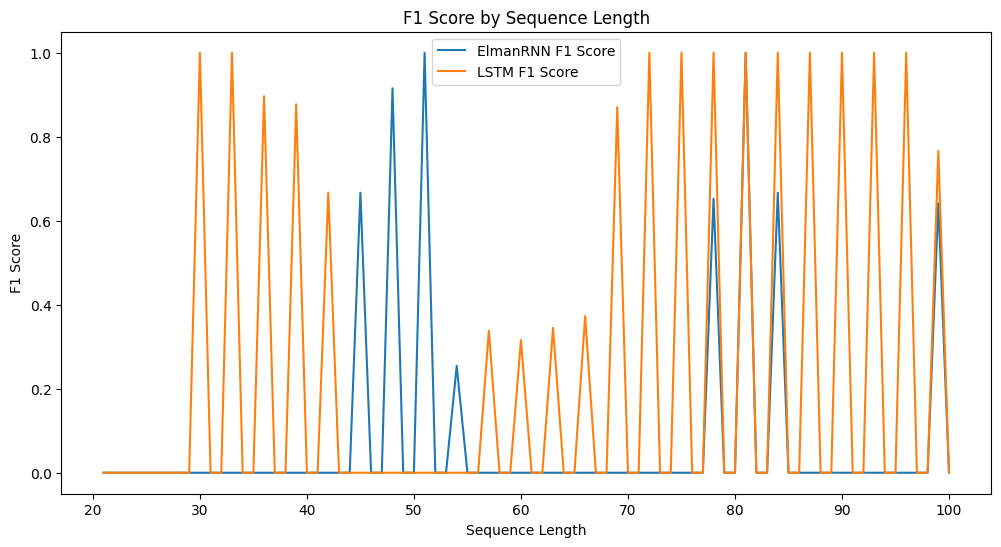

In [260]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_by_length(model, data_loader):
    model.eval()
    length_to_accuracy = {}
    length_to_f1 = {}

    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            lengths = torch.tensor([len(seq) for seq in sequences]).to(device)

            outputs = model(sequences.unsqueeze(-1).float(), lengths)
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()

            for i, seq in enumerate(sequences):
                length = len(seq)
                if length not in length_to_accuracy:
                    length_to_accuracy[length] = []
                    length_to_f1[length] = []

                true_label = labels[i].cpu().numpy()
                pred_label = predicted[i].cpu().numpy()

                length_to_accuracy[length].append(true_label == pred_label)
                length_to_f1[length].append((true_label, pred_label))

    # Calculate average accuracy and F1 score for each length
    avg_length_to_accuracy = {length: np.mean(acc) for length, acc in length_to_accuracy.items()}
    avg_length_to_f1 = {length: f1_score(*zip(*length_to_f1[length])) for length in length_to_f1.keys()}

    return avg_length_to_accuracy, avg_length_to_f1


# Evaluate RNN and LSTM by sentence length
rnn_length_to_accuracy, rnn_length_to_f1 = evaluate_by_length(rnn_model, test_loader)
lstm_length_to_accuracy, lstm_length_to_f1 = evaluate_by_length(lstm_model, test_loader)

# Plot performance over sentence length
lengths = list(range(21, 101))
rnn_accuracies = [rnn_length_to_accuracy.get(length, 0) for length in lengths]
rnn_f1_scores = [rnn_length_to_f1.get(length, 0) for length in lengths]
lstm_accuracies = [lstm_length_to_accuracy.get(length, 0) for length in lengths]
lstm_f1_scores = [lstm_length_to_f1.get(length, 0) for length in lengths]

plt.figure(figsize=(12, 6))
plt.plot(lengths, rnn_f1_scores, label='ElmanRNN F1 Score')
plt.plot(lengths, lstm_f1_scores, label='LSTM F1 Score')
plt.xlabel('Sequence Length')
plt.ylabel('F1 Score')
plt.title('F1 Score by Sequence Length')
plt.legend()
# plt.tight_layout()
plt.show()


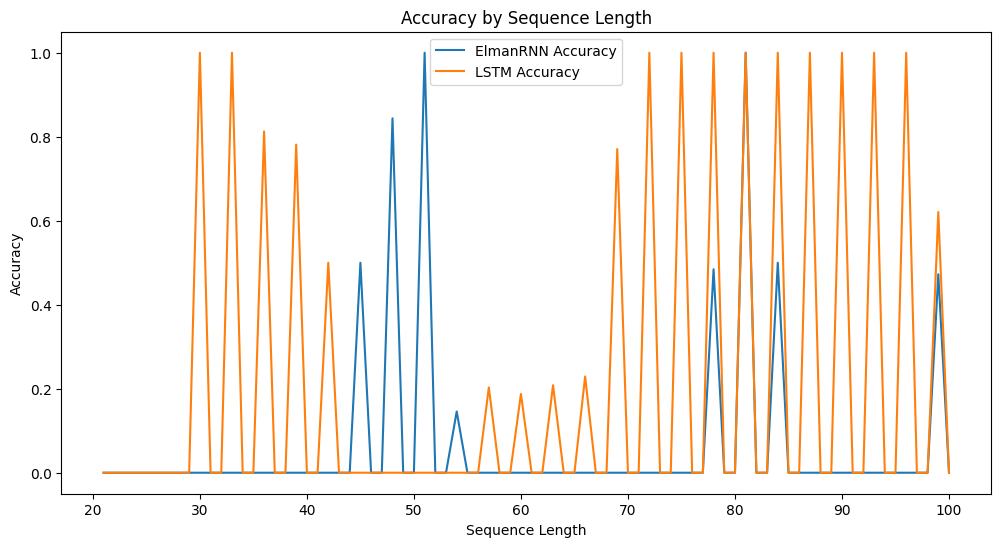

In [261]:
plt.figure(figsize=(12, 6))
plt.plot(lengths, rnn_accuracies, label='ElmanRNN Accuracy')
plt.plot(lengths, lstm_accuracies, label='LSTM Accuracy')
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Accuracy by Sequence Length')
plt.legend()
plt.show()